In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Load the dataset
df = pd.read_csv('Tamil_Cuisine_Analysis.csv')

# Pre-processing
# Remove special characters and convert to lowercase
df['ingredients'] = df['ingredients'].apply(lambda x: re.sub('[^a-zA-Z0-9\n\.]', ' ', x.lower()))
df['recipe_name'] = df['recipe_name'].apply(lambda x: re.sub('[^a-zA-Z0-9\n\.]', ' ', x.lower()))

# Feature engineering
# Encode meal_type, cuisine and diet columns using LabelEncoder
label_enc = LabelEncoder()
df['meal_type'] = label_enc.fit_transform(df['meal_type'])
df['cuisine'] = label_enc.fit_transform(df['cuisine'])
df['diet'] = label_enc.fit_transform(df['diet'])

# Convert the ingredients column into a matrix of TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['ingredients'])

# Combine the encoded columns with the TF-IDF features
encoded_df = pd.DataFrame({'meal_type': df['meal_type'],
                           'cuisine': df['cuisine'],
                           'diet': df['diet']})
feature_matrix = np.hstack((encoded_df, tfidf_matrix.toarray()))

# Save the feature matrix and target variable (calories) for modeling
np.save('feature_matrix.npy', feature_matrix)
np.save('target.npy', df['calories'])


In [ ]:

# Load the feature matrix and target variable
X = np.load('feature_matrix.npy')
y = np.load('target.npy')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the decision tree regressor
dtr = DecisionTreeRegressor(random_state=42)

# Define the hyperparameters to tune
parameters = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(dtr, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best hyperparameters to fit the model
best_dtr = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
best_dtr.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_dtr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)


Best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score:  0.12641854268227776
Mean squared error:  27595.412318367347


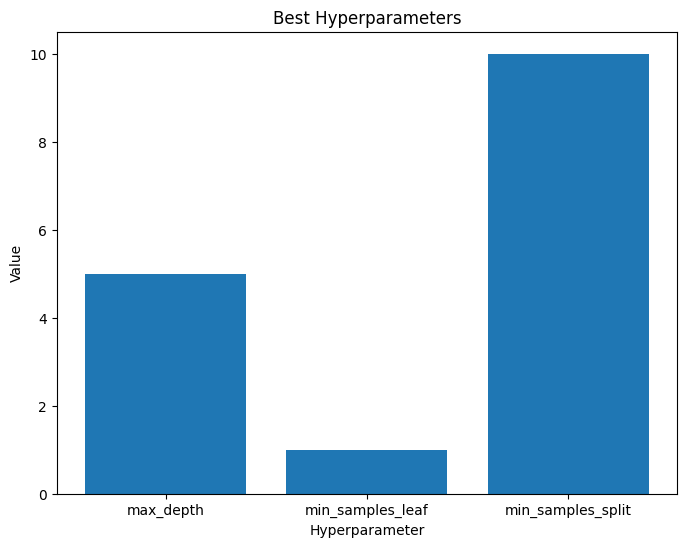

In [ ]:
import matplotlib.pyplot as plt

# Get the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Create a bar chart of the best hyperparameters
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(best_params.keys(), best_params.values())
ax.set_title('Best Hyperparameters')
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Value')
plt.show()
